# Imports And Data Loading


In [4]:
# Kaggle package Installation
!pip install /kaggle/input/rdkit-wheel/rdkit_pypi-2022.9.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install mordred --no-index --find-links=file:///kaggle/input/mordred-1-2-0-py3-none-any/

# Imports
import warnings
import mordred
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Processing /kaggle/input/rdkit-wheel/rdkit_pypi-2022.9.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
rdkit-pypi is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Looking in links: file:///kaggle/input/mordred-1-2-0-py3-none-any/
/kaggle/input/neurips-open-polymer-prediction-2025/sample_submission.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train.csv
/kaggle/input/neurips-open-polymer-prediction-2025/test.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset2.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset4.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset1.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset3.csv
/kaggle/input/rdkit-wheel/pillow-11.2.1-cp311-cp311-manylinux_2_28_x86_64.whl
/kaggle/input/rdkit-wheel/numpy-2.3.0-cp311-cp311-manylinux_2_28_x86_64.whl
/kaggle

In [9]:
# kaggle Data Import
train_df = pd.read_csv("/kaggle/input/neurips-open-polymer-prediction-2025/train.csv")
new_data = pd.read_csv("/kaggle/input/neurips-open-polymer-prediction-2025/test.csv")

#Google Colab Data Import
# train_df = pd.read_csv(os.path.join(neurips_open_polymer_prediction_2025_path, 'train.csv'))
# new_data = pd.read_csv(os.path.join(neurips_open_polymer_prediction_2025_path, 'test.csv'))

# View first few rows
train_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


# Exploratory Data Analysis

In [ ]:
# Info about data types and nulls
df.info()

# Summary of missing values
missing = df.isnull().sum()
print("Missing values in each column:\n", missing[missing > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7973 entries, 0 to 7972
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       7973 non-null   int64  
 1   SMILES   7973 non-null   object 
 2   Tg       511 non-null    float64
 3   FFV      7030 non-null   float64
 4   Tc       737 non-null    float64
 5   Density  613 non-null    float64
 6   Rg       614 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 436.2+ KB
Missing values in each column:
 Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64


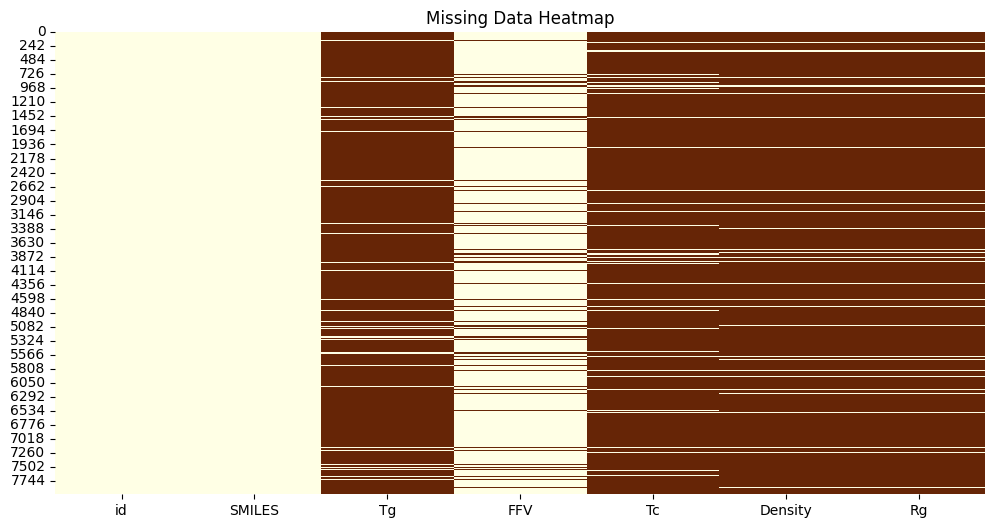

In [ ]:
#Heatmap showing missing data
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='YlOrBr')
plt.title("Missing Data Heatmap")
plt.show()

In [ ]:
# Show summary stats for numeric columns
df.describe()

,id,Tg,FFV,Tc,Density,Rg
count,7.973000e+03,511.000000,7030.000000,737.000000,613.000000,614.000000
mean,1.080050e+09,96.452314,0.367212,0.256334,0.985484,16.419787
std,6.218241e+08,111.228279,0.029609,0.089538,0.146189,4.608640
min,8.781700e+04,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,5.376641e+08,13.674509,0.349549,0.186000,0.890243,12.540328
50%,1.079079e+09,74.040183,0.364264,0.236000,0.948193,15.052194
75%,1.621708e+09,161.147595,0.380790,0.330500,1.062096,20.411067
max,2.147438e+09,472.250000,0.777097,0.524000,1.840999,34.672906


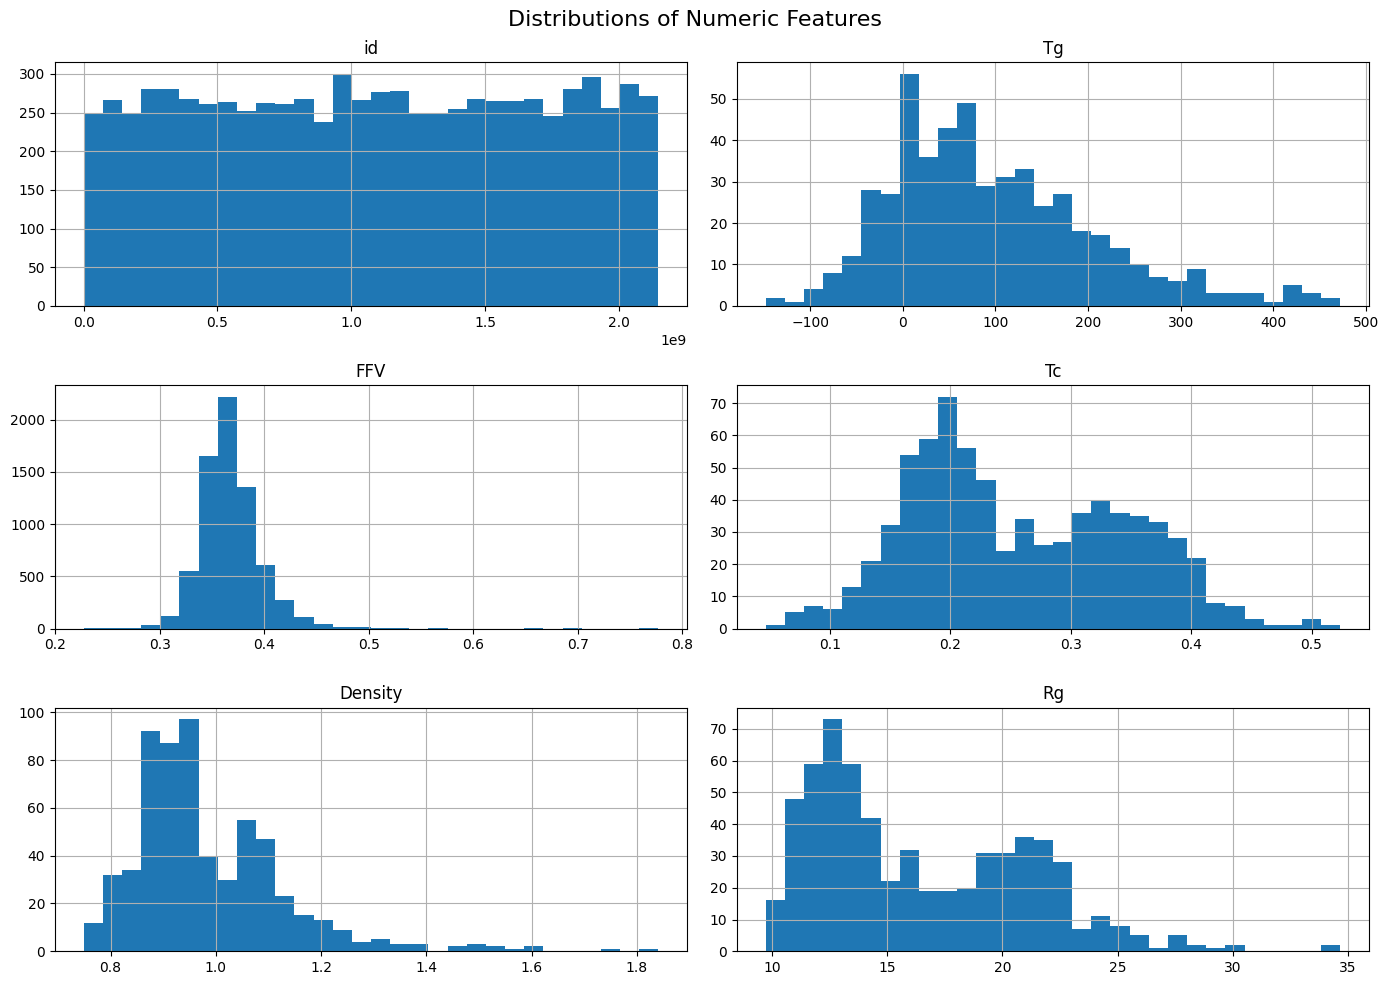

In [ ]:
# Select numeric columns only
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Plot histograms
df[numeric_cols].hist(figsize=(14, 10), bins=30)
plt.suptitle("Distributions of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

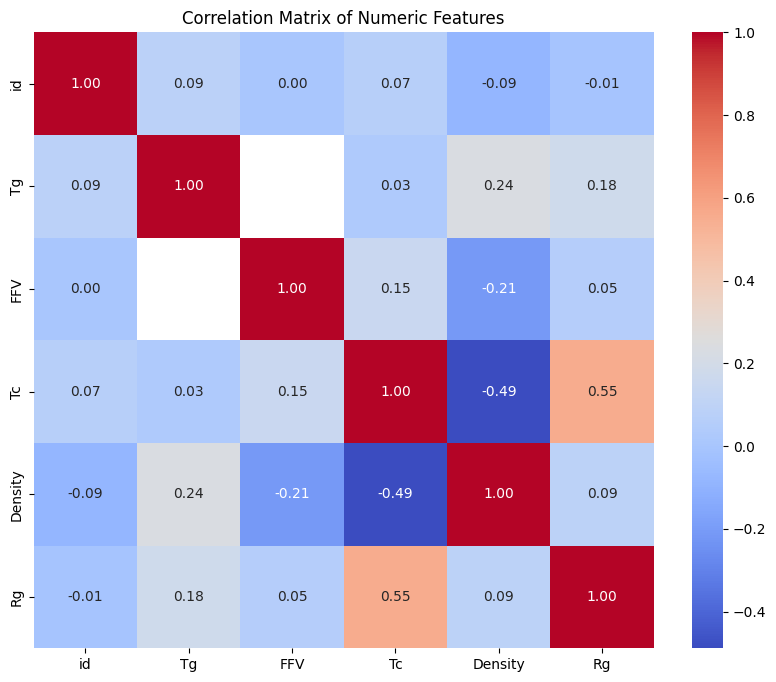

In [ ]:
#correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

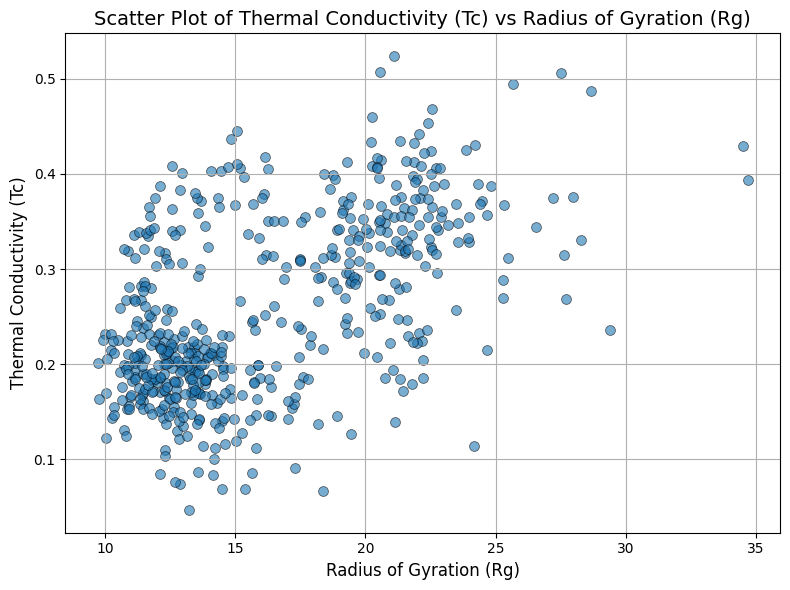

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Rg', y='Tc', alpha=0.6, s=50, edgecolor='k')

plt.title('Scatter Plot of Thermal Conductivity (Tc) vs Radius of Gyration (Rg)', fontsize=14)
plt.xlabel('Radius of Gyration (Rg)', fontsize=12)
plt.ylabel('Thermal Conductivity (Tc)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Engineering


## Code

In [11]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, MACCSkeys, rdmolops
import networkx as nx
from collections import Counter
from mordred import Calculator, descriptors
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from tqdm import tqdm
import warnings

# Suppress RDKit warnings
warnings.filterwarnings("ignore")

# === Feature Category Definitions ===
FEATURE_CATEGORIES = {
    "rdkit": [],
    "graph": [
        'graph_diameter', 'avg_shortest_path', 'num_cycles',
        'betweenness_mean', 'betweenness_std', 'eigenvector_mean',
        'ring_4', 'max_degree', 'closeness_mean', 'katz_centrality_std',
        'heteroatom_ratio'
    ],
    "mordred": ['AMW', 'TIC2', 'naRing', 'MPC3'],
    "maccs": ['MACCS_Key130', 'MACCS_Key142', 'MACCS_Key066', 'MACCS_Key153'],
    "topo_torsion": ['TopologicalTorsion_Bit0512', 'TopologicalTorsion_Bit1296'],
    "atom_pair": ['AtomPair_B512_Bit0138', 'AtomPair_B512_Bit0448', 'AtomPair_B512_Bit0408'],
}

# === Useless RDKit Descriptors to Exclude ===
USELESS_COLS = [
    'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
    'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
    'NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_barbitur',
    'fr_benzodiazepine', 'fr_dihydropyridine', 'fr_epoxide', 'fr_isothiocyan',
    'fr_lactam', 'fr_nitroso', 'fr_prisulfonamd', 'fr_thiocyan',
    'MaxEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons',
    'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Kappa1',
    'LabuteASA', 'HeavyAtomCount', 'MolMR', 'Chi3n', 'BertzCT', 'Chi2v',
    'Chi4n', 'HallKierAlpha', 'Chi3v', 'Chi4v', 'MinAbsPartialCharge',
    'MinPartialCharge', 'MaxAbsPartialCharge', 'FpDensityMorgan2',
    'FpDensityMorgan3', 'Phi', 'Kappa3', 'fr_nitrile', 'SlogP_VSA6',
    'NumAromaticCarbocycles', 'NumAromaticRings', 'fr_benzene', 'VSA_EState6',
    'NOCount', 'fr_C_O', 'fr_C_O_noCOO', 'NumHDonors', 'fr_amide',
    'fr_Nhpyrrole', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_COO2',
    'fr_halogen', 'fr_diazo', 'fr_nitro_arom', 'fr_phos_ester'
]

# === RDKit descriptor initialization ===
def initialize_rdkit_features(useless_cols):
    return [d[0] for d in Descriptors.descList if d[0] not in useless_cols]

# === Feature Extraction Function ===
def compute_molecular_features_for_smiles(smiles, useless_cols):
    try:
        results = {}
        mol = Chem.MolFromSmiles(smiles)
        rdkit_names = FEATURE_CATEGORIES["rdkit"]

        # RDKit
        if mol:
            rdkit_vals = [d[1](mol) for d in Descriptors.descList if d[0] in rdkit_names]
            results.update(dict(zip(rdkit_names, rdkit_vals)))
        else:
            results.update({name: None for name in rdkit_names})

        # Graph
        graph_defaults = {k: 0 for k in FEATURE_CATEGORIES['graph']}
        if mol:
            try:
                adj = rdmolops.GetAdjacencyMatrix(mol)
                G = nx.from_numpy_array(adj)
                if nx.is_connected(G):
                    results['graph_diameter'] = nx.diameter(G)
                    results['avg_shortest_path'] = nx.average_shortest_path_length(G)
                    closeness = list(nx.closeness_centrality(G).values())
                    results['closeness_mean'] = np.mean(closeness)
                else:
                    results.update({k: 0 for k in ['graph_diameter', 'avg_shortest_path', 'closeness_mean']})

                results['max_degree'] = max([d for _, d in G.degree()]) if G else 0
                cycles = list(nx.cycle_basis(G))
                results['num_cycles'] = len(cycles)
                results['ring_4'] = sum(1 for c in cycles if len(c) == 4)

                try:
                    b = list(nx.betweenness_centrality(G).values())
                    results['betweenness_mean'] = np.mean(b)
                    results['betweenness_std'] = np.std(b)
                except:
                    results['betweenness_mean'] = results['betweenness_std'] = 0

                try:
                    e = list(nx.eigenvector_centrality(G).values())
                    results['eigenvector_mean'] = np.mean(e)
                except:
                    results['eigenvector_mean'] = 0

                try:
                    k = list(nx.katz_centrality(G, max_iter=1000).values())
                    results['katz_centrality_std'] = np.std(k)
                except:
                    results['katz_centrality_std'] = 0

                atom_types = [atom.GetSymbol() for atom in mol.GetAtoms()]
                total = len(atom_types)
                hetero = total - atom_types.count('C')
                results['heteroatom_ratio'] = hetero / total if total > 0 else 0

            except:
                results.update(graph_defaults)
        else:
            results.update(graph_defaults)

        # Mordred
        mordred_defaults = {k: 0 for k in FEATURE_CATEGORIES['mordred']}
        if mol:
            try:
                calc = Calculator([
                    descriptors.Weight,
                    descriptors.InformationContent,
                    descriptors.RingCount,
                    descriptors.PathCount
                ])
                m = calc(mol)
                results['AMW'] = float(m.get('Weight.AMW', 0))
                results['TIC2'] = float(m.get('InformationContent.TIC2', 0))
                results['naRing'] = float(m.get('RingCount.naRing', 0))
                results['MPC3'] = float(m.get('PathCount.MPC3', 0))
            except:
                results.update(mordred_defaults)
        else:
            results.update(mordred_defaults)

        # MACCS
        maccs_defaults = {k: 0 for k in FEATURE_CATEGORIES['maccs']}
        if mol:
            try:
                fp = MACCSkeys.GenMACCSKeys(mol)
                bits = [int(x) for x in fp.ToBitString()]
                results['MACCS_Key130'] = bits[129]
                results['MACCS_Key142'] = bits[141]
                results['MACCS_Key066'] = bits[65]
                results['MACCS_Key153'] = bits[152]
            except:
                results.update(maccs_defaults)
        else:
            results.update(maccs_defaults)

        # Topological Torsion
        torsion_defaults = {k: 0 for k in FEATURE_CATEGORIES['topo_torsion']}
        if mol:
            try:
                fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048)
                bits = [int(x) for x in fp.ToBitString()]
                results['TopologicalTorsion_Bit0512'] = bits[512]
                results['TopologicalTorsion_Bit1296'] = bits[1296]
            except:
                results.update(torsion_defaults)
        else:
            results.update(torsion_defaults)

        # Atom Pair
        atom_pair_defaults = {k: 0 for k in FEATURE_CATEGORIES['atom_pair']}
        if mol:
            try:
                fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=512)
                bits = [int(x) for x in fp.ToBitString()]
                results['AtomPair_B512_Bit0138'] = bits[138]
                results['AtomPair_B512_Bit0448'] = bits[448]
                results['AtomPair_B512_Bit0408'] = bits[408]
            except:
                results.update(atom_pair_defaults)
        else:
            results.update(atom_pair_defaults)

        return results

    except Exception as e:
        print(f"Critical error on {smiles}: {e}")
        return None

# === Parallel Feature Processing ===
def process_molecular_features_parallel(df, useless_cols, n_jobs=4):
    if n_jobs == -1:
        n_jobs = cpu_count()

    print(f"\n🔄 Using joblib with {n_jobs} parallel workers...")

    # ✅ Proper RDKit init before parallel
    FEATURE_CATEGORIES["rdkit"] = initialize_rdkit_features(useless_cols)

    smiles_list = df['SMILES'].tolist()

    results = Parallel(n_jobs=n_jobs, verbose=0)(
    delayed(lambda s: {"SMILES": s, **compute_molecular_features_for_smiles(s, useless_cols)})(smiles)
    for smiles in tqdm(smiles_list, desc="🔬 Computing Features")
)

    valid_results = [r for r in results if r is not None]
    if not valid_results:
        print("⚠️ No valid molecular features computed")
        return pd.DataFrame()

    df_result = pd.DataFrame(valid_results)
    df_result = df_result.replace([np.inf, -np.inf], np.nan)

    print("\n✅ Feature extraction complete.")
    summarize_features(df_result)

    return df_result

# === Summary Reporter ===
def summarize_features(df):
    print("\n📊 Feature Summary by Category:")
    for cat, features in FEATURE_CATEGORIES.items():
        found = [f for f in features if f in df.columns]
        print(f" - {cat.upper():<12}: {len(found)} features")
    print(f"\n🧬 Total features: {df.shape[1]}")


In [ ]:

if __name__ == "__main__":

    data = train_df

    feature_df = process_molecular_features_parallel(data, USELESS_COLS, n_jobs=4)


🔄 Using joblib with 4 parallel workers...


🔬 Computing Features: 100%|██████████| 7973/7973 [14:27<00:00,  9.19it/s]



✅ Feature extraction complete.

📊 Feature Summary by Category:
 - RDKIT       : 149 features
 - GRAPH       : 11 features
 - MORDRED     : 4 features
 - MACCS       : 4 features
 - TOPO_TORSION: 2 features
 - ATOM_PAIR   : 3 features

🧬 Total features: 174


In [ ]:
feature_df

,SMILES,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,FpDensityMorgan1,AvgIpc,...,MPC3,MACCS_Key130,MACCS_Key142,MACCS_Key066,MACCS_Key153,TopologicalTorsion_Bit0512,TopologicalTorsion_Bit1296,AtomPair_B512_Bit0138,AtomPair_B512_Bit0448,AtomPair_B512_Bit0408
0,*CC(*)c1ccccc1C(=O)OCCCCCC,12.144536,0.105927,-0.105927,0.500278,13.705882,232.323,NaN,1.411765,2.456411,...,0,1,0,0,0,0,0,0,1,0
1,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,3.523412,0.098918,0.098918,0.125364,16.777778,598.919,NaN,0.577778,3.135512,...,0,1,1,0,0,0,0,1,1,0
2,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,13.714745,0.107441,-3.829434,0.092387,16.301370,1003.207,NaN,0.397260,3.440040,...,0,1,0,0,1,1,0,1,1,1
3,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,3.978671,0.054569,-0.202102,0.209590,11.523810,542.726,NaN,0.333333,3.051372,...,0,0,1,0,0,0,0,0,1,0
4,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,13.703218,0.068062,-0.686332,0.014164,15.885714,965.154,NaN,0.557143,4.071253,...,0,1,0,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7968,*Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1,12.522270,0.172388,-0.436195,0.311026,11.423077,352.430,NaN,0.961538,2.700410,...,0,1,0,0,1,0,0,0,1,0
7969,*C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...,13.679392,0.005765,-0.729725,0.044063,13.714286,750.680,NaN,0.678571,3.617202,...,0,1,0,0,0,1,0,1,1,1
7970,*c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...,13.555573,0.193809,-0.612298,0.313025,14.897436,521.573,NaN,0.743590,3.347371,...,0,1,0,0,0,0,0,0,1,1
7971,*C=C(*)c1ccccc1C,2.502315,0.396204,0.396204,0.528143,14.555556,116.163,NaN,1.666667,2.041467,...,0,0,0,0,0,0,0,0,1,0


##  Summary

This pipeline extracts **173 molecular features** from SMILES using RDKit, NetworkX, Mordred, and fingerprints — optimized for **interpretability**, **structural diversity**, and **efficiency**.

### 🔍 Feature Breakdown
- **RDKit**: Physicochemical descriptors (e.g., MW, logP)
- **Graph**: Molecular topology via NetworkX (e.g., cycles, centrality)
- **Mordred**: Compact complexity & connectivity metrics
- **MACCS**: Substructure presence (binary keys)
- **Torsion / Atom Pair**: Encoded 3D-like connectivity (bit vectors)

 **Designed for structure–activity modeling and fast parallel computation.**


  Topological Torsion & Atom Pair Features

| Feature Name                    | Source Function (RDKit)                                | What It Captures                                 | Why It's Useful                                 |
|---------------------------------|--------------------------------------------------------|---------------------------------------------------|-------------------------------------------------|
| `TopologicalTorsion_Bit0512`    | `GetHashedTopologicalTorsionFingerprintAsBitVect`     | Presence of a 4-atom torsion pattern (bit 512)   | Encodes conformational and topological info     |
| `TopologicalTorsion_Bit1296`    | Same as above                                          | Presence of another torsion substructure (bit 1296) | Adds specificity for torsion-based interactions |
| `AtomPair_B512_Bit0138`         | `GetHashedAtomPairFingerprintAsBitVect`               | Atom pair pattern at certain distance (bit 138)  | Captures spatial atom relationships             |
| `AtomPair_B512_Bit0408`         | Same as above                                          | Another frequent atom pair pattern               | Helps differentiate isomers                     |
| `AtomPair_B512_Bit0448`         | Same as above                                          | Yet another atom pair pattern                    | Encodes spatial structure efficiently           |


  Graph-Based Features

| Feature Name             | Source Function (NetworkX)         | What It Captures                              | Why It's Useful                             |
|--------------------------|-------------------------------------|------------------------------------------------|---------------------------------------------|
| `graph_diameter`         | `nx.diameter`                       | Longest shortest path in graph                | Reflects molecular size and complexity      |
| `avg_shortest_path`      | `nx.average_shortest_path_length`  | Mean path length between atoms                | Captures compactness of the structure       |
| `num_cycles`             | `nx.cycle_basis`                   | Number of cycles in molecule                  | Indicates ring systems, structural motifs   |
| `ring_4`                 | `nx.cycle_basis`                   | Count of 4-membered rings                     | Detects strain-prone or reactive subrings   |
| `max_degree`             | `G.degree()`                       | Max atomic connectivity (node degree)         | Reflects branching or star-like patterns    |
| `closeness_mean`         | `nx.closeness_centrality`          | Avg closeness of atoms to others              | Highlights central vs peripheral atoms      |
| `betweenness_mean`       | `nx.betweenness_centrality`        | Avg fraction of shortest paths through atom   | Identifies key connectors or "bridges"      |
| `betweenness_std`        | `nx.betweenness_centrality`        | Spread of betweenness values                  | Diversity in importance of atoms            |
| `eigenvector_mean`       | `nx.eigenvector_centrality`        | Avg influence based on neighbors’ importance  | Identifies highly connected substructures   |
| `katz_centrality_std`    | `nx.katz_centrality`               | Variation in node centrality with attenuation | Captures global vs local influence          |
| `heteroatom_ratio`       | Custom from `mol.GetAtoms()`       | Fraction of non-carbon atoms                  | Proxy for chemical diversity / bioactivity  |


**Mordred**

| **Descriptor** | **Group**          | **Full Name**                             | **What It Measures**                                                                    | **Why It Was Selected**                                                                                            |
| -------------- | ------------------ | ----------------------------------------- | --------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| `AMW`          | Weight             | Average Molecular Weight                  | The average atomic mass per atom in the molecule.                                       | ✅ Physically interpretable and correlates well with bulk molecular properties like Tg and density.                 |
| `TIC2`         | InformationContent | 2nd Order Total Information Content Index | A measure of molecular complexity based on atom types and their neighborhood diversity. | ✅ Reflects structural diversity and has shown strong predictive power in polymers and materials science tasks.     |
| `naRing`       | RingCount          | Number of Aromatic Rings                  | Total count of aromatic rings in the molecule.                                          | ✅ Useful for characterizing polymer backbone types (e.g., aromatic vs aliphatic), important for Tg, Tc prediction. |
| `MPC3`         | TopologicalIndex   | Molecular Path Count (order 3)            | Number of paths of length 3 in the molecular graph.                                     | ✅ Captures mid-range connectivity — important for encoding shape and flexibility of molecular structure.           |


 Fingerprint Bits

| Descriptor Bit              | Reason for Selection                                                    |
| --------------------------- | ----------------------------------------------------------------------- |
| TopologicalTorsion\_Bit0512 | Captures specific torsional arrangements (e.g., conformational freedom) |
| TopologicalTorsion\_Bit1296 | Linked to complex connectivity relevant to polymer rigidity             |
| AtomPair\_B512\_Bit0138     | Encodes spatial relationships between specific atom pairs               |
| AtomPair\_B512\_Bit0448     | Often correlates with backbone substructures                            |
| AtomPair\_B512\_Bit0408     | Captures electrostatic or steric effects from atom pair topology        |


  MACCS Keys

| MACCS Key     | Bit Index | Chemical Relevance                                | Reason for Selection                                    |
| ------------- | --------- | ------------------------------------------------- | ------------------------------------------------------- |
| MACCS\_Key066 | 66        | Atom environment (e.g., specific O-H/C=O)         | Common in polymer backbones and affects H-bonding       |
| MACCS\_Key130 | 130       | Specific substructure (e.g., heteroatom patterns) | Distinguishes functionalized monomers/subunits          |
| MACCS\_Key142 | 142       | Typically linked to aromatic substitutions        | Important in π-π stacking & rigidity in polymer systems |
| MACCS\_Key153 | 153       | Reactive or polar group detection                 | Correlates with solubility and crosslinking potential   |

## Final Merge

In [ ]:
# Keep only SMILES and target columns from train_df
target_columns = ['SMILES', 'Density', 'Tc', 'Tg', 'Rg', 'FFV']
targets_df = train_df[target_columns]

# Merge features with targets
final_df = pd.merge(feature_df, targets_df, on='SMILES')
final_df

,SMILES,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,FpDensityMorgan1,AvgIpc,...,TopologicalTorsion_Bit0512,TopologicalTorsion_Bit1296,AtomPair_B512_Bit0138,AtomPair_B512_Bit0448,AtomPair_B512_Bit0408,Density,Tc,Tg,Rg,FFV
0,*CC(*)c1ccccc1C(=O)OCCCCCC,12.144536,0.105927,-0.105927,0.500278,13.705882,232.323,NaN,1.411765,2.456411,...,0,0,0,1,0,NaN,0.205667,NaN,NaN,0.374645
1,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,3.523412,0.098918,0.098918,0.125364,16.777778,598.919,NaN,0.577778,3.135512,...,0,0,1,1,0,NaN,NaN,NaN,NaN,0.370410
2,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,13.714745,0.107441,-3.829434,0.092387,16.301370,1003.207,NaN,0.397260,3.440040,...,1,0,1,1,1,NaN,NaN,NaN,NaN,0.378860
3,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,3.978671,0.054569,-0.202102,0.209590,11.523810,542.726,NaN,0.333333,3.051372,...,0,0,0,1,0,NaN,NaN,NaN,NaN,0.387324
4,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,13.703218,0.068062,-0.686332,0.014164,15.885714,965.154,NaN,0.557143,4.071253,...,0,0,1,1,1,NaN,NaN,NaN,NaN,0.355470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7968,*Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1,12.522270,0.172388,-0.436195,0.311026,11.423077,352.430,NaN,0.961538,2.700410,...,0,0,0,1,0,NaN,NaN,NaN,NaN,0.367498
7969,*C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...,13.679392,0.005765,-0.729725,0.044063,13.714286,750.680,NaN,0.678571,3.617202,...,1,0,1,1,1,NaN,NaN,NaN,NaN,0.353280
7970,*c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...,13.555573,0.193809,-0.612298,0.313025,14.897436,521.573,NaN,0.743590,3.347371,...,0,0,0,1,1,NaN,NaN,NaN,NaN,0.369411
7971,*C=C(*)c1ccccc1C,2.502315,0.396204,0.396204,0.528143,14.555556,116.163,NaN,1.666667,2.041467,...,0,0,0,1,0,NaN,NaN,261.662355,NaN,NaN


# Cleaning Data

In [ ]:
import numpy as np

# Assume feature_cols contains all your descriptor/fingerprint columns (exclude targets and SMILES)
feature_cols = [col for col in final_df.columns if col not in ['SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']]

# Convert all feature columns to numeric (in case of object/string types)
final_df[feature_cols] = final_df[feature_cols].apply(pd.to_numeric, errors='coerce')

# Replace infinities with NaN
final_df[feature_cols] = final_df[feature_cols].replace([np.inf, -np.inf], np.nan)

# Fill NaNs with column medians
final_df[feature_cols] = final_df[feature_cols].fillna(final_df[feature_cols].median())

# Clip extreme values (choose a reasonable threshold)
max_threshold = 1e6
min_threshold = -1e6

final_df[feature_cols] = final_df[feature_cols].clip(lower=min_threshold, upper=max_threshold)

# Optional: log-transform columns known to have large ranges, e.g. 'Ipc', 'WPath', if present
for col in ['Ipc', 'WPath']:
    if col in final_df.columns:
        # Clip negatives to zero to avoid log issues, then log1p transform
        final_df[col] = np.log1p(final_df[col].clip(lower=0))



# Train and Evaluate Model

## Random Forest Regressor

In [ ]:
from sklearn.model_selection import train_test_split

X = final_df.drop(columns=['SMILES', 'Density', 'Tc', 'Tg', 'Rg', 'FFV']) #features
y = final_df[['Density', 'Tc', 'Tg', 'Rg', 'FFV']] #targets


In [ ]:
# Replace with your actual target column names
targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# Features are all columns except SMILES and targets
feature_cols = [col for col in final_df.columns if col not in ['SMILES'] + targets]



In [ ]:
from autogluon.tabular import TabularPredictor
import os

# Targets to predict
targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
descriptor_names = final_df.drop(columns=targets + ['SMILES'], errors='ignore').columns.tolist()

# Storage
predictors = {}
leaderboards = {}
maes = {}

for target in targets:
    print(f"\n🔧 AutoGluon training for target: {target}")

    # Prepare target-specific data
    data = final_df.dropna(subset=[target]).copy()
    data = data[descriptor_names + [target]]

    # Split manually for evaluation consistency
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

    # Save to disk (AutoGluon reads from file sometimes internally)
    save_path = f'ag_models_{target}'
    os.makedirs(save_path, exist_ok=True)

    # Train
    predictor = TabularPredictor(label=target, path=save_path, eval_metric='mae').fit(
        train_data=train_data,
        time_limit=300,  # seconds, optional
        presets='best_quality',  # Try 'medium_quality' if you're low on time
    )

    # Predict and evaluate
    y_pred = predictor.predict(val_data)
    mae = mean_absolute_error(val_data[target], y_pred)

    print(f"✅ {target} MAE: {mae:.4f}")
    maes[target] = mae

    # Save model & leaderboard
    predictors[target] = predictor
    leaderboards[target] = predictor.leaderboard(val_data, silent=True)



🔧 Training model for target: Tg
✅ R² Score: 0.5250
📉 MAE: 54.0135
📊 Range: 519.3182 | Samples: 128

🔧 Training model for target: FFV
✅ R² Score: 0.7490
📉 MAE: 0.0076
📊 Range: 0.5395 | Samples: 1758

🔧 Training model for target: Tc
✅ R² Score: 0.7814
📉 MAE: 0.0260
📊 Range: 0.4410 | Samples: 185

🔧 Training model for target: Density
✅ R² Score: 0.7571
📉 MAE: 0.0392
📊 Range: 1.0923 | Samples: 154

🔧 Training model for target: Rg
✅ R² Score: 0.6887
📉 MAE: 1.6853
📊 Range: 24.9446 | Samples: 154


# Compute Weights and Final wMAE:

In [ ]:
# Step 1: Compute raw weights
raw_weights = {
    t: (1 / np.sqrt(n_samples[t])) / ranges[t] if ranges[t] != 0 else 0
    for t in targets
}

# Step 2: Normalize weights
total_weight = sum(raw_weights.values())
weights = {t: w / total_weight for t, w in raw_weights.items()}

# Step 3: Compute wMAE
wmae = sum(weights[t] * maes[t] for t in targets)

print("\n📊 Weighted MAE (wMAE) Breakdown:")
for t in targets:
    print(f"{t}: MAE={maes[t]:.4f}, Weight={weights[t]:.4f}, Weighted={weights[t] * maes[t]:.4f}")

print(f"\n✅ Final Weighted MAE (wMAE): {wmae:.6f}")


📊 Weighted MAE (wMAE) Breakdown:
Tg: MAE=54.0135, Weight=0.0006, Weighted=0.0319
FFV: MAE=0.0076, Weight=0.1535, Weighted=0.0012
Tc: MAE=0.0260, Weight=0.5787, Weighted=0.0150
Density: MAE=0.0392, Weight=0.2561, Weighted=0.0100
Rg: MAE=1.6853, Weight=0.0112, Weighted=0.0189

✅ Final Weighted MAE (wMAE): 0.077047
